In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
from order_book import OrderBook
from datetime import datetime, timedelta
from market_data_vwap_snapper.utils import create_connection
import json

DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S.%f' 
DEPTH_LEVELS_TO_GET = 200


def clear_output_and_print(string_to_print):
    clear_output(wait=True)
    print(string_to_print)
        
def remove_level_if_exists(tree,level):
    if level in tree:
        del tree[level]

def update_book(book,orderbook_update):
    """takes a orderbook_update model and applies it to the book"""
    bids_overrides = json.loads(orderbook_update[8])
    asks_overrides = json.loads(orderbook_update[9])
    for bid in bids_overrides:
        price = float(bid[0])
        size = float(bid[1])
        remove_level_if_exists(book._bids,price)
        if size != 0:
            book.submit_order(order_type='lmt', side='bid', size=size, price=price, participant_id=0)
    for ask in asks_overrides:
        price = float(ask[0])
        size = float(ask[1])
        remove_level_if_exists(book._asks,price)
        if size!=0:
            book.submit_order(order_type='lmt', side='ask', size=size, price=price, participant_id=0)
    book.external_time = datetime.strptime(orderbook_update[4],DATETIME_FORMAT)
    
def get_vwap(book,vwap_depth):
    vwap_lb = book[book[:,1].cumsum() < vwap_depth]
    vwap_ub = book[book[:,1].cumsum() >= vwap_depth]
    if vwap_ub.size ==0: # vwap could not be resolved due to insufficient depth
        return np.nan
    vwap_lb_val = np.dot(vwap_lb[:,1],vwap_lb[:,0])
    vwap_ub_val = (vwap_depth - vwap_lb[:,1].sum()) * vwap_ub[0,0]
    vwap = (vwap_lb_val + vwap_ub_val)/vwap_depth
    return vwap

def generate_vwaps_list(order_book, vwap_depths_usd):
    both_sides = order_book.get_mkt_depth(DEPTH_LEVELS_TO_GET)
    bids_np = np.array(both_sides[1])
    asks_np = np.array(both_sides[0])
    bids_size = bids_np.sum(axis=0)[1]
    asks_size = asks_np.sum(axis=0)[1]
    mid_rate = (order_book.bid + order_book.ask)/2
    current_vwap_snaps = []
    for vwap_depth_usd in vwap_depths_usd:
        vwap_depth_ccy = vwap_depth_usd/mid_rate
        bid_vwap = get_vwap(bids_np,vwap_depth_ccy)
        ask_vwap = get_vwap(asks_np,vwap_depth_ccy)
        current_vwap_snaps.append({
            'orderbook_snapshot_id':order_book.orderbook_snapshot_id,
            'external_time':order_book.external_time,
            'vwap_depth_usd':vwap_depth_usd,
            'bid_vwap':bid_vwap,
            'ask_vwap':ask_vwap,
            'top_bid':order_book.bid,
            'top_ask':order_book.ask,
            'total_ask_size':order_book._total_ask_size,
            'total_bid_size':order_book._total_bid_size,
            'bids_size':bids_size,
            'asks_size':asks_size,
            'levels_extracted':DEPTH_LEVELS_TO_GET,
                        })
    return current_vwap_snaps

def load_book_from_snapshot(orderbook_snapshot):
    provider = orderbook_snapshot[4]
    # internal_pair = f"{orderbook_snapshot[2]}-{orderbook_snapshot[3]}" # columns selected external_time,base,counter,provider,bids,asks
    order_book = OrderBook()
    for bid in json.loads(orderbook_snapshot[5]):
        order_book.submit_order(order_type='lmt', side='bid', size=float(bid[1]), price=float(bid[0]), participant_id=0)
    for ask in json.loads(orderbook_snapshot[6]):
        order_book.submit_order(order_type='lmt', side='ask', size=float(ask[1]), price=float(ask[0]), participant_id=0)
        
    book_time = datetime.strptime(orderbook_snapshot[1],DATETIME_FORMAT)
    order_book.external_time = book_time
    order_book.orderbook_snapshot_id = orderbook_snapshot[0]
    order_book.base = orderbook_snapshot[2]
    order_book.counter = orderbook_snapshot[3]
    order_book.provider = provider
    return order_book

In [2]:
VWAP_STORE_EVERY_X_SECONDS = 1
VWAP_DEPTHS_USD = [50,100,200,300,400,500,750,1_000,5_000,10_000,20_000,30_000,40_000,50_000,75_000,100_000,200_000,300_000,400_000,500_000,600_000,700_000,800_000,900_000,1_000_000]

In [3]:
conn = create_connection('market_data.sqlite')
cur = conn.cursor()

### Get book snapshots

In [4]:
# columns selected orderbook_snapshot_id, external_time,base,counter,provider,bids,asks
cur.execute(f"""
with all_books as (
SELECT 
                count(*) over (partition by base,counter,provider order by external_time desc) as rnum,
                s.*
                FROM orderbook_snapshots s
                where true
                )
                select 
                id as orderbook_snapshot_id, external_time,base,counter,provider,bids,asks, rnum, base ||'_' || counter || '_'|| provider as book_key
                from all_books
                where true
                and rnum = 1 -- get latest book before time we are interested in
order by external_time
                
                
                
                """)
orderbook_snapshots_list = cur.fetchall()
orderbook_snapshots_names = list(map(lambda x: x[0], cur.description))
orderbook_snapshots_df = pd.DataFrame(orderbook_snapshots_list,columns=orderbook_snapshots_names)
orderbook_snapshots_df

,orderbook_snapshot_id,external_time,base,counter,provider,bids,asks,rnum,book_key
0,4566,2024-05-27 16:22:45.355087,BTC,USD,bitstamp,"[[""70355"", ""0.00505634""], [""70353"", ""0.0497487...","[[""70365"", ""0.04974090""], [""70368"", ""0.2131676...",1,BTC_USD_bitstamp


### Load book snapshots

In [33]:
# %%timeit
bookid_to_book_map = {}
bookid_last_vwap_time_map = {}
for counter, orderbook_snapshot in enumerate(orderbook_snapshots_list):
    order_book = load_book_from_snapshot(orderbook_snapshot)
    bookid_last_vwap_time_map[orderbook_snapshot[0]] = datetime(2000,1,1) # init to old value
    bookid_to_book_map[orderbook_snapshot[0]] = order_book    
#     clear_output_and_print(f"done {counter+1}/{len(orderbook_snapshots_list)}. {orderbook_snapshot[2]}-{orderbook_snapshot[3]} {orderbook_snapshot[4]}. {orderbook_snapshot[1]}")

### Load orderbook updates

In [36]:
tick1 = datetime.now()
snapshot_ids_str = ",".join([str(i) for i in orderbook_snapshots_df.orderbook_snapshot_id.unique()])
conn = create_connection('market_data.sqlite')
cur = conn.cursor()
cur.execute(f"""
        select 
            id, orderbook_snapshot_id, created_at, received_at, external_time, base, counter,
            provider, bids_overrides, asks_overrides
            FROM orderbook_level_overrides
        where true
        and orderbook_snapshot_id in ({snapshot_ids_str})
        and base = 'BTC'
        order by external_time -- NEED TO BE SORTED BY EXTERNAL_TIME OR PROCESSING LOGIC WILL NOT WORK
                """)
orderbook_updates_list = cur.fetchall()
orderbook_updates_names = list(map(lambda x: x[0], cur.description))
orderbook_updates_df = pd.DataFrame(orderbook_updates_list,columns=orderbook_updates_names)
print(len(orderbook_updates_list))
tock1 = datetime.now()
print(tock1-tick1)
if orderbook_updates_list:
    print(f"from {orderbook_updates_list[0][4]} to {orderbook_updates_list[-1][4]}")

31
0:00:00.005846
from 2024-05-27 13:47:06.202666 to 2024-05-27 13:47:10.947831


In [42]:
# orderbook_updates_df[(orderbook_updates_df['base'] == 'BTC') & (orderbook_updates_df['provider'] == 'bitstamp')]

In [43]:
tick = datetime.now()

vwap_snaps = []
for counter,orderbook_update in enumerate(orderbook_updates_list):
#     time.sleep(0.5)
    book_of_update = bookid_to_book_map.get(orderbook_update[1])
#     if counter%10_000 == 0:clear_output_and_print(f"processing. external_time: {book_of_update.external_time}. orderbook_snapshot_id: {book_of_update.orderbook_snapshot_id}")

    if book_of_update:
        update_book(book_of_update,orderbook_update)
        time_since_last_vwap_for_current_book_seconds = (book_of_update.external_time - bookid_last_vwap_time_map[orderbook_update[1]]).total_seconds()
        if  time_since_last_vwap_for_current_book_seconds > VWAP_STORE_EVERY_X_SECONDS:
            bookid_last_vwap_time_map[book_of_update.orderbook_snapshot_id] = book_of_update.external_time

            current_vwap_snaps = generate_vwaps_list(book_of_update, VWAP_DEPTHS_USD)
            vwap_snaps += current_vwap_snaps
        
    else:
        raise ValueError(f"Book is misssing. for ID {orderbook_update[1]}")
#         missed_books_count[orderbook_update[1]] = missed_books_count.get(orderbook_update[1],0) + 1
tock = datetime.now()
print(tock-tick)

0:00:00.046412


In [106]:
# book_state_before_time = pd.to_datetime('2023-12-27 16:32:44.990')

# tick = datetime.now()

# vwap_snaps = []
# for counter,orderbook_update in enumerate(orderbook_updates_list):
# #     time.sleep(0.5)
#     book_of_update = bookid_to_book_map.get(orderbook_update[1])
# #     if counter%10_000 == 0:clear_output_and_print(f"processing. external_time: {book_of_update.external_time}. orderbook_snapshot_id: {book_of_update.orderbook_snapshot_id}")

#     if book_of_update:
#         if pd.to_datetime(orderbook_update[4]) > book_state_before_time:
#             print(f"reached desired state")
#             break
#         update_book(book_of_update,orderbook_update)
#         time_since_last_vwap_for_current_book_seconds = (book_of_update.external_time - bookid_last_vwap_time_map[orderbook_update[1]]).total_seconds()
#         if  time_since_last_vwap_for_current_book_seconds > VWAP_STORE_EVERY_X_SECONDS:
#             bookid_last_vwap_time_map[book_of_update.orderbook_snapshot_id] = book_of_update.external_time

#             current_vwap_snaps = generate_vwaps_list(book_of_update, VWAP_DEPTHS_USD)
#             vwap_snaps += current_vwap_snaps
        
#     else:
#         raise ValueError(f"Book is misssing. for ID {orderbook_update[1]}")
# #         missed_books_count[orderbook_update[1]] = missed_books_count.get(orderbook_update[1],0) + 1
# tock = datetime.now()
# print(tock-tick)

* Time to do 1 day and 16 hours (1 snap every 60 sec) -- 1:38:07.368430
* Time to do 1 day and 16 hours (1 snap every 1 sec) -- 2:28:25.097588

In [44]:
book_dump = book_of_update.get_mkt_depth(10)
bids_dump = book_dump[1]
asks_dump = book_dump[0]
bids_dump_df = pd.DataFrame(bids_dump,columns = ['bids_price','bids_size'])
asks_dump_df = pd.DataFrame(asks_dump,columns = ['asks_price','bids_size'])
pd.concat([bids_dump_df,asks_dump_df],axis=1)

,bids_price,bids_size,asks_price,bids_size
0,68849.30,0.071000,68851.47,0.100000
1,68848.68,0.055160,68851.48,0.000100
2,68848.13,0.000100,68851.59,0.000100
3,68848.02,0.000100,68852.03,0.030503
4,68847.72,0.000164,68852.69,0.072619
5,68847.00,0.000100,68855.08,0.123293
6,68846.82,0.106104,68855.09,0.145233
7,68846.81,0.014524,68855.59,0.001256
8,68846.12,0.000100,68855.73,0.059000
9,68846.10,0.000100,68857.01,0.000100


In [46]:
pd.to_datetime(orderbook_updates_list[-1][4]) - pd.to_datetime(orderbook_updates_list[0][4])

Timedelta('0 days 00:00:04.745165')

In [47]:
vwap_snaps_df_raw = pd.DataFrame(vwap_snaps)
vwap_snaps_df = pd.merge(vwap_snaps_df_raw,orderbook_snapshots_df[['orderbook_snapshot_id','base','counter','provider']],on = 'orderbook_snapshot_id')
vwap_snaps_df['spread_bp'] = 10000*(vwap_snaps_df['ask_vwap'] - vwap_snaps_df['bid_vwap'])/((vwap_snaps_df['ask_vwap'] + vwap_snaps_df['bid_vwap'])/2)

In [48]:
# vwap_snaps_df

<Axes: xlabel='external_time'>

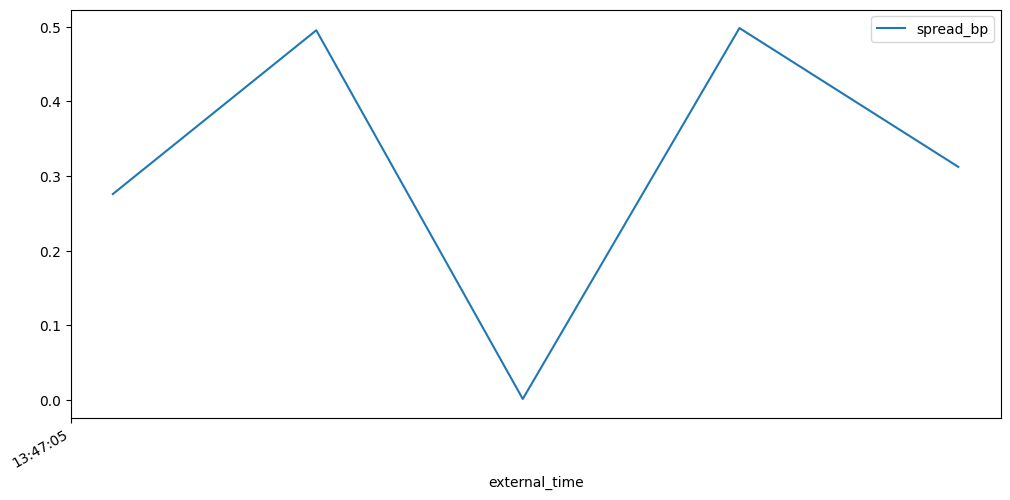

In [49]:
focus_base = 'BTC'
focus_depth = 50
vwap_snaps_df[(vwap_snaps_df.base == focus_base) & (vwap_snaps_df.vwap_depth_usd == focus_depth)].set_index('external_time')[['spread_bp']].plot(figsize = (12,6))

In [57]:
vwap_snaps_df_raw.to_csv('vwap_snaps_df_raw.csv')

In [58]:
vwap_snaps_df_raw

,orderbook_snapshot_id,external_time,vwap_depth_usd,bid_vwap,ask_vwap,top_bid,top_ask,total_ask_size,total_bid_size,bids_size,asks_size,levels_extracted
0,1,2023-12-27 16:25:24.492073,50,43085.900000,43086.000000,43085.9,43086.0,1.267017,45.628932,23.963244,1.267017,200
1,1,2023-12-27 16:25:24.492073,100,43085.900000,43086.000000,43085.9,43086.0,1.267017,45.628932,23.963244,1.267017,200
2,1,2023-12-27 16:25:24.492073,200,43085.900000,43086.000000,43085.9,43086.0,1.267017,45.628932,23.963244,1.267017,200
3,1,2023-12-27 16:25:24.492073,300,43085.900000,43086.000000,43085.9,43086.0,1.267017,45.628932,23.963244,1.267017,200
4,1,2023-12-27 16:25:24.492073,400,43085.900000,43086.000000,43085.9,43086.0,1.267017,45.628932,23.963244,1.267017,200
...,...,...,...,...,...,...,...,...,...,...,...,...
33070,1,2023-12-27 16:42:27.823525,600000,43111.042793,43125.433347,43124.0,43124.1,22560.641035,53263.942141,106.791161,93.110788,200
33071,1,2023-12-27 16:42:27.823525,700000,43110.268305,43127.256468,43124.0,43124.1,22560.641035,53263.942141,106.791161,93.110788,200
33072,1,2023-12-27 16:42:27.823525,800000,43109.672267,43128.884375,43124.0,43124.1,22560.641035,53263.942141,106.791161,93.110788,200
33073,1,2023-12-27 16:42:27.823525,900000,43109.152190,43130.231495,43124.0,43124.1,22560.641035,53263.942141,106.791161,93.110788,200
